In [60]:
import numpy as np
import pandas as pd
import struct
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [61]:
def leer_gadget2_por_tipo(path_del_archivo):
    with open(path_del_archivo, "rb") as f:
        # Leer header
        f.seek(0)
        _ = struct.unpack("I", f.read(4))[0]
        header_bytes = f.read(256)
        _ = struct.unpack("I", f.read(4))[0]

        # numero_de_particulas = número de partículas por tipo_de_particula
        numero_de_particulas = struct.unpack("6I", header_bytes[0:24])
        masas_del_header = struct.unpack("6d", header_bytes[24:72])  # masas por tipo_de_particula si son iguales
        total_de_particulas = sum(numero_de_particulas)
        tipos_presentes = [i for i, n in enumerate(numero_de_particulas) if n >= 0]

        print(f"Tipos presentes: total de particulas: {list(zip(tipos_presentes, numero_de_particulas))}")
        print(f"Total de partículas: {total_de_particulas:,}")

        # Leer POS
        _ = struct.unpack("I", f.read(4))[0]
        posiciones = np.fromfile(f, dtype=np.float32, count=total_de_particulas * 3).reshape((total_de_particulas, 3))
        _ = struct.unpack("I", f.read(4))[0]

        # Leer VEL
        _ = struct.unpack("I", f.read(4))[0]
        velocidades = np.fromfile(f, dtype=np.float32, count=total_de_particulas * 3).reshape((total_de_particulas, 3))
        _ = struct.unpack("I", f.read(4))[0]

        # Leer IDs
        _ = struct.unpack("I", f.read(4))[0]
        ids = np.fromfile(f, dtype=np.uint32, count=total_de_particulas)
        _ = struct.unpack("I", f.read(4))[0]

        # Leer masas si hay (algunas simulaciones lo hacen)
        masas = None

        try:
            _ = struct.unpack("I", f.read(4))[0]
            masas = np.fromfile(f, dtype=np.float32, count=total_de_particulas)
            _ = struct.unpack("I", f.read(4))[0]

        except:
         masas = None

    # Separar los datos por tipo_de_particula de partícula
    bases_de_datos_por_tipo = {}
    offset = 0

    for tipo_de_particula, cantidad_de_particulas in enumerate(numero_de_particulas):
        
        if cantidad_de_particulas == 0:
            continue

        # Obtener fragmentos por tipo_de_particula
        posicion = posiciones[offset : offset + cantidad_de_particulas]
        velocidad = velocidades[offset : offset + cantidad_de_particulas]
        id = ids[offset : offset + cantidad_de_particulas]

        if masas is not None:
            masa = masas[offset : offset + cantidad_de_particulas]

        elif masas_del_header[tipo_de_particula] != 0:
            masa = np.full(cantidad_de_particulas, masas_del_header[tipo_de_particula])
            
        else:
            masa = None

        informacion_galaxia = {
            "id": id,
            "x": posicion[:, 0],
            "y": posicion[:, 1],
            "z": posicion[:, 2],
            "vx": velocidad[:, 0],
            "vy": velocidad[:, 1],
            "vz": velocidad[:, 2]
        }

        if masa is not None:
            informacion_galaxia["masa"] = masa

        componente_df = pd.DataFrame(informacion_galaxia)
        bases_de_datos_por_tipo[str(tipo_de_particula)] = componente_df

        offset += cantidad_de_particulas

    return bases_de_datos_por_tipo

# Uso
archivo = r"Archivos\AM2229-735_host_RL_050"
dfs = leer_gadget2_por_tipo(archivo)

materia_oscura_df = dfs['1']
disco_df = dfs['2']
bulbo_df = dfs['3']


Tipos presentes: total de particulas: [(0, 0), (1, 2339761), (2, 1396500), (3, 598500), (4, 0), (5, 0)]
Total de partículas: 4,334,761


In [62]:
def centrar_galaxia(base_de_datos):
    
    global masa_total_galaxia 
    
    masa_total_galaxia = base_de_datos.masa.sum()

    x_cm = base_de_datos.masa @ base_de_datos.x / masa_total_galaxia
    y_cm = base_de_datos.masa @ base_de_datos.y / masa_total_galaxia
    z_cm = base_de_datos.masa @ base_de_datos.z / masa_total_galaxia

    vx_cm = base_de_datos.masa @ base_de_datos.vx / masa_total_galaxia
    vy_cm = base_de_datos.masa @ base_de_datos.vy / masa_total_galaxia
    vz_cm = base_de_datos.masa @ base_de_datos.vz / masa_total_galaxia
    
    # Posiciones trasladadas
    base_de_datos['x0'] = base_de_datos.x - x_cm
    base_de_datos['y0'] = base_de_datos.y - y_cm
    base_de_datos['z0'] = base_de_datos.z - z_cm

    # Velocidades trasladadas
    base_de_datos['vx0'] = base_de_datos.vx - vx_cm
    base_de_datos['vy0'] = base_de_datos.vy - vy_cm
    base_de_datos['vz0'] = base_de_datos.vz - vz_cm

centrar_galaxia(materia_oscura_df)
centrar_galaxia(disco_df)
centrar_galaxia(bulbo_df)

In [63]:
def rotar_galaxia(base_de_datos):
    lx = (base_de_datos.y0 @ base_de_datos.vz0) - (base_de_datos.z0 @ base_de_datos.vy0)
    ly = (base_de_datos.z0 @ base_de_datos.vx0) - (base_de_datos.x0 @ base_de_datos.vz0)
    lz = (base_de_datos.x0 @ base_de_datos.vy0) - (base_de_datos.y0 @ base_de_datos.vx0)

    magnitud_l = np.linalg.norm((lx, ly, lz))

    angulo_z = np.atan(ly / lx)
    angulo_y = np.acos(lz / magnitud_l)
     
    cos_z = np.cos(angulo_z)
    sin_z = np.sin(angulo_z)
    cos_y = np.cos(angulo_y)
    sin_y = np.sin(angulo_y)

    # Rotar posiciones
    base_de_datos['x_f'] = (
        base_de_datos.x0 * (cos_y * cos_z) + 
        base_de_datos.y0 * (cos_y * sin_z) +
        base_de_datos.z0 * (- sin_y)
        )
    
    base_de_datos['y_f'] = (
        base_de_datos.x0 * (- sin_z) + 
        base_de_datos.y0 * (cos_z)
        )

    base_de_datos['z_f'] = (
        base_de_datos.x0 * (sin_y * cos_z) + 
        base_de_datos.y0 * (sin_y * sin_z) +
        base_de_datos.z0 * (cos_y)
        )
    
    # Rotar velocidades
    base_de_datos['vx_f'] = (
        base_de_datos.vx0 * (cos_y * cos_z) + 
        base_de_datos.vy0 * (cos_y * sin_z) +
        base_de_datos.vz0 * (- sin_y)
        )
    
    base_de_datos['vy_f'] = (
        base_de_datos.vx0 * (- sin_z) + 
        base_de_datos.vy0 * (cos_z)
        )

    base_de_datos['vz_f'] = (
        base_de_datos.vx0 * (sin_y * cos_z) + 
        base_de_datos.vy0 * (sin_y * sin_z) +
        base_de_datos.vz0 * (cos_y)
        )

rotar_galaxia(materia_oscura_df)
rotar_galaxia(disco_df)
rotar_galaxia(bulbo_df)


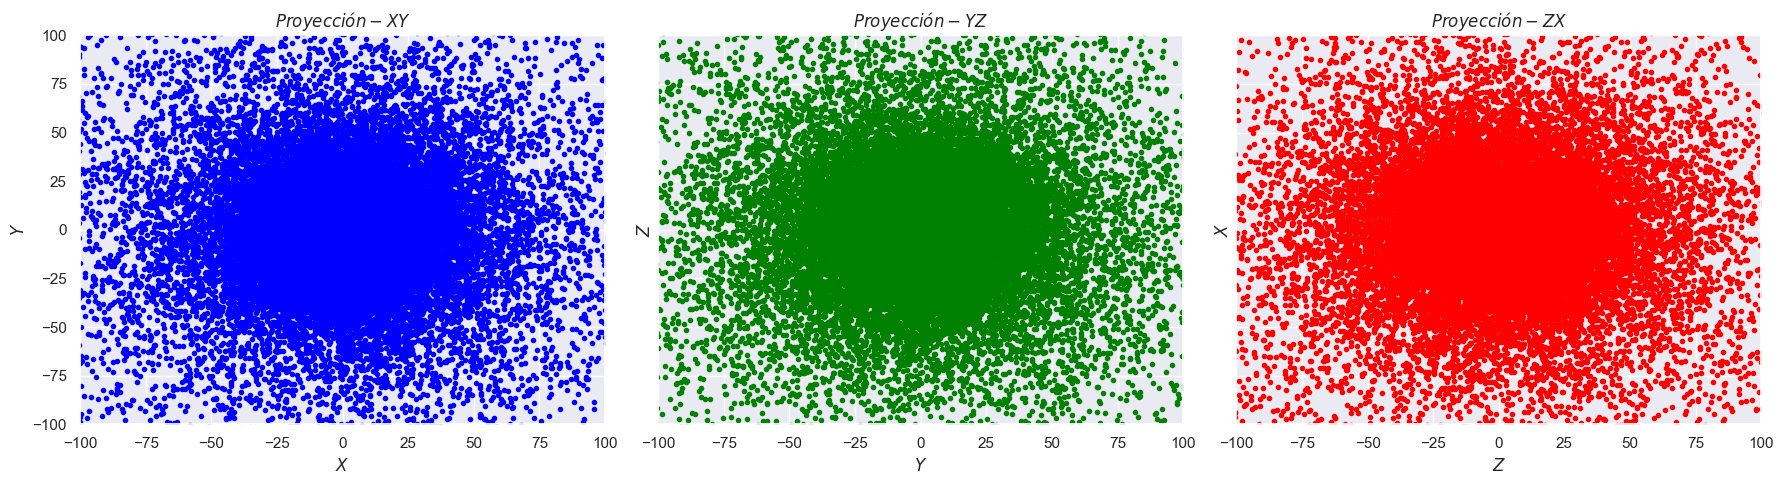

In [64]:
def graficar_proyecciones(base_de_datos, x, y, z, limites_x = (None, None), limites_y = (None, None)):

    # Creamos una figura con 3 subplots en una sola fila (1 fila, 3 columnas)
    _, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)  # Ancho x alto en pulgadas

    # Primer gráfico: masa vs radio
    axs[0].scatter(base_de_datos[x], base_de_datos[y], color='blue', marker= '.')
    axs[0].set_title(r'$Proyección-XY$')
    axs[0].set_xlabel(r'$X$')
    axs[0].set_ylabel(r'$Y$')
    axs[0].set_xlim(limites_x[0], limites_x[1])
    axs[0].set_ylim(limites_y[0], limites_y[1])

    # Segundo gráfico
    axs[1].scatter(base_de_datos[y], base_de_datos[z], color='green', marker= '.')
    axs[1].set_title(r'$Proyección-YZ$')
    axs[1].set_xlabel(r'$Y$')
    axs[1].set_ylabel(r'$Z$')

    # Tercer gráfico
    axs[2].scatter(base_de_datos[z], base_de_datos[x], color='red', marker= '.')
    axs[2].set_title(r'$Proyección-ZX$')
    axs[2].set_xlabel(r'$Z$')
    axs[2].set_ylabel(r'$X$')

    # Ajustar los espacios entre los subplots para evitar superposición
    plt.tight_layout()
    plt.show()
    
graficar_proyecciones(bulbo_df, 'x_f', 'y_f', 'z_f', limites_x=(-100, 100), limites_y=(-100,100))


In [65]:
def calcular_perfil_de_densidad_superficial(base_de_datos, delta_r_xy = 0.2):
    base_de_datos['r_xy'] = np.sqrt( base_de_datos.x_f**2 + base_de_datos.y_f**2)

    r_xy_min = base_de_datos.r_xy.min()
    r_xy_max = base_de_datos.r_xy.max()
    total_radios_arandelas = np.int32((r_xy_max - r_xy_min) / delta_r_xy)

    radios_arandelas = np.linspace(r_xy_min, r_xy_max, total_radios_arandelas)
    suma_de_radios = radios_arandelas[1:] + radios_arandelas[:-1]
    area_arandelas = np.pi * delta_r_xy * suma_de_radios


    base_de_datos['intervalo_arandela'] = pd.cut(base_de_datos.r_xy, bins = radios_arandelas, right=False, labels=np.arange(radios_arandelas.__len__()-1))

    perfil_de_densidad_superficial_df = base_de_datos[['masa','intervalo_arandela']].groupby('intervalo_arandela', observed = False).sum()
    perfil_de_densidad_superficial_df['area'] = area_arandelas
    perfil_de_densidad_superficial_df['densidad'] = perfil_de_densidad_superficial_df.masa / perfil_de_densidad_superficial_df.area
    perfil_de_densidad_superficial_df['densidad_log10'] = np.log10(perfil_de_densidad_superficial_df.densidad)
    perfil_de_densidad_superficial_df['radio_medio'] = suma_de_radios/2 

    return perfil_de_densidad_superficial_df
    
perfil_de_densidad_superficial_disco_df = calcular_perfil_de_densidad_superficial(disco_df)

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [66]:
def calcular_perfil_de_densidad_volumetrico(base_de_datos, delta_r_xyz = 0.2):
    base_de_datos['r_xyz'] = np.sqrt( base_de_datos.x_f**2 + base_de_datos.y_f**2 + base_de_datos.z_f**2)

    r_xyz_min = base_de_datos.r_xyz.min()
    r_xyz_max = base_de_datos.r_xyz.max()
    total_radios_casquetes = np.int32((r_xyz_max - r_xyz_min) / delta_r_xyz)

    radios_casquetes = np.linspace(r_xyz_min, r_xyz_max, total_radios_casquetes)
    r1 = radios_casquetes[:-1]
    r2 = radios_casquetes[1:] 
    volumen_casquetes = (4/3) * np.pi * delta_r_xyz * (r1**2 + r1*r2 + r2**2)

    base_de_datos['intervalo_casquete'] = pd.cut(base_de_datos.r_xyz, bins = radios_casquetes, right=False, labels=np.arange(radios_casquetes.__len__()-1))

    perfil_de_densidad_volumetrico_df = base_de_datos[['masa','intervalo_casquete']].groupby('intervalo_casquete', observed = False).sum()
    perfil_de_densidad_volumetrico_df['volumen'] = volumen_casquetes
    perfil_de_densidad_volumetrico_df['densidad'] = perfil_de_densidad_volumetrico_df.masa / perfil_de_densidad_volumetrico_df.volumen
    perfil_de_densidad_volumetrico_df['radio_medio'] = (r1 + r2)/2 
    perfil_de_densidad_volumetrico_df['densidad_log10'] = np.log10(perfil_de_densidad_volumetrico_df.densidad)
    perfil_de_densidad_volumetrico_df['radio_medio_log10'] = np.log10(perfil_de_densidad_volumetrico_df.radio_medio)

    return perfil_de_densidad_volumetrico_df
    
perfil_de_densidad_volumetrico_materia_oscura_df = calcular_perfil_de_densidad_volumetrico(materia_oscura_df)
perfil_de_densidad_volumetrico_bulbo_df = calcular_perfil_de_densidad_volumetrico(bulbo_df)

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [67]:
def calcular_perfil_de_densidad_lineal(base_de_datos, delta_z = 0.1):
    z_min = base_de_datos.z_f.min()
    z_max = base_de_datos.z_f.max()
    total_limites_intervalos = np.int32((z_max - z_min) / delta_z)

    limites_intervalos = np.linspace(z_min, z_max, total_limites_intervalos)
    z1 = limites_intervalos[1:] 
    z2 = limites_intervalos[:-1]
    longitud_segmentos = abs(z2 - z1)

    base_de_datos['intervalo_segmento'] = pd.cut(base_de_datos.z_f, bins = limites_intervalos, right=False, labels=np.arange(limites_intervalos.__len__()-1))

    perfil_de_densidad_lineal_df = base_de_datos[['masa','intervalo_segmento']].groupby('intervalo_segmento', observed = False).sum()
    perfil_de_densidad_lineal_df['longitud'] = longitud_segmentos
    perfil_de_densidad_lineal_df['densidad'] = perfil_de_densidad_lineal_df.masa / perfil_de_densidad_lineal_df.longitud
    perfil_de_densidad_lineal_df['densidad_log10'] = np.log10(perfil_de_densidad_lineal_df.densidad)
    perfil_de_densidad_lineal_df['z_medio'] = (z1 + z2)/2 

    return perfil_de_densidad_lineal_df

perfil_de_densidad_lineal_disco_df = calcular_perfil_de_densidad_lineal(disco_df)

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


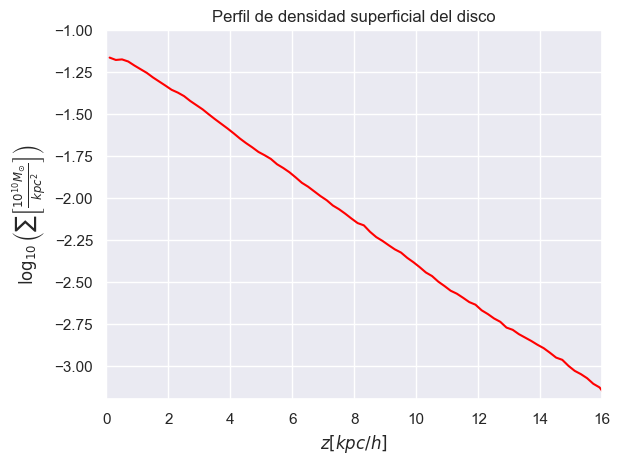

In [88]:
ax = sns.lineplot(perfil_de_densidad_superficial_disco_df, x='radio_medio', y='densidad_log10', color='red')
ax.set_title(r'Perfil de densidad superficial del disco')
ax.set_xlim((0,16))
ax.set_ylim((-3.2, -1))
ax.set_xlabel(r'$z\left[{kpc}/{h}\right]$')
ax.set_ylabel(r'$\log_{10}\left(\sum\left[\frac{10^{10}M_{\odot}}{{kpc}^{2}}\right]\right)$')
plt.show()

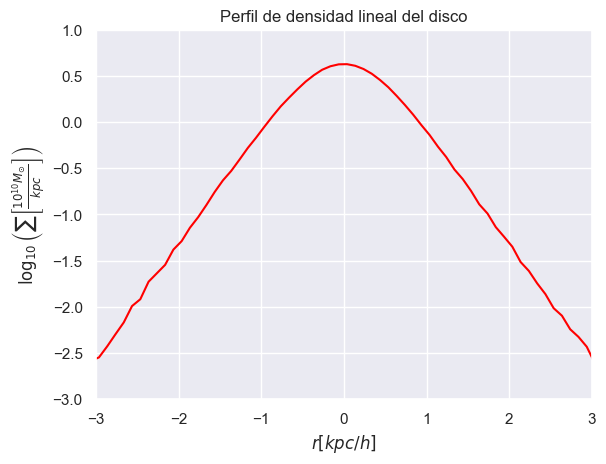

In [84]:
ax = sns.lineplot(perfil_de_densidad_lineal_disco_df, x='z_medio', y='densidad_log10', color='red')
ax.set_title(r'Perfil de densidad lineal del disco')
ax.set_xlim((-3,3))
ax.set_ylim((-3, 1))
ax.set_xlabel(r'$r\left[{kpc}/{h}\right]$')
ax.set_ylabel(r'$\log_{10}\left(\sum\left[\frac{10^{10}M_{\odot}}{kpc}\right]\right)$')
plt.show()

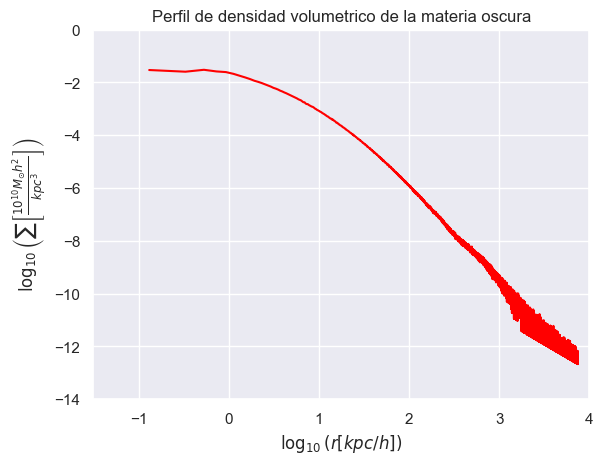

In [86]:
ax = sns.lineplot(perfil_de_densidad_volumetrico_materia_oscura_df, x='radio_medio_log10', y='densidad_log10', color='red')
ax.set_title(r'Perfil de densidad volumetrico de la materia oscura')
ax.set_xlim((-1.5,4))
ax.set_ylim((-14, 0))
ax.set_xlabel(r'$\log_{10}(r\left[{kpc}/{h}\right])$')
ax.set_ylabel(r'$\log_{10}\left(\sum\left[\frac{10^{10}M_{\odot}h^{2}}{{kpc}^{3}}\right]\right)$')
plt.show()

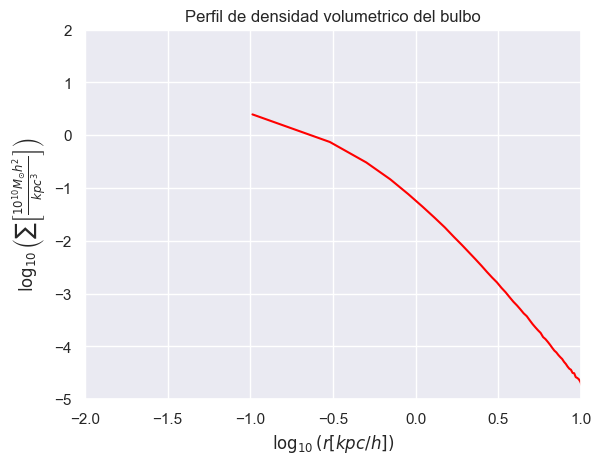

In [92]:
ax = sns.lineplot(perfil_de_densidad_volumetrico_bulbo_df, x='radio_medio_log10', y='densidad_log10', color='red')
ax.set_title(r'Perfil de densidad volumetrico del bulbo')
ax.set_xlim((-2, 1))
ax.set_ylim((-5, 2))
ax.set_xlabel(r'$\log_{10}(r\left[{kpc}/{h}\right])$')
ax.set_ylabel(r'$\log_{10}\left(\sum\left[\frac{10^{10}M_{\odot}h^{2}}{{kpc}^{3}}\right]\right)$')
plt.show()